In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Aggregation Method: Mean

For **mean aggregation**, we want to calculate the values

$F(t, T) = \frac{1}{T}\int_t^{t+T} f(\tau) d\tau$

where:
- $t$ is the starting timepoint
- $T$ is the length of the period

The objective of the plot is to communicate this array of $F$ values over all $t, T$ pairs. Specifically, $T$ is plotted on the x-axis, while the distribution of $F_{T}(t)$ values for each $T$ is plotted by percentile lines along the y-axis.


## Waveform Generation

no. of samples: 20000
0.00000   -1.397708
0.00005    1.298188
0.00010   -2.712290
0.00015   -0.878132
0.00020   -0.930376
dtype: float64


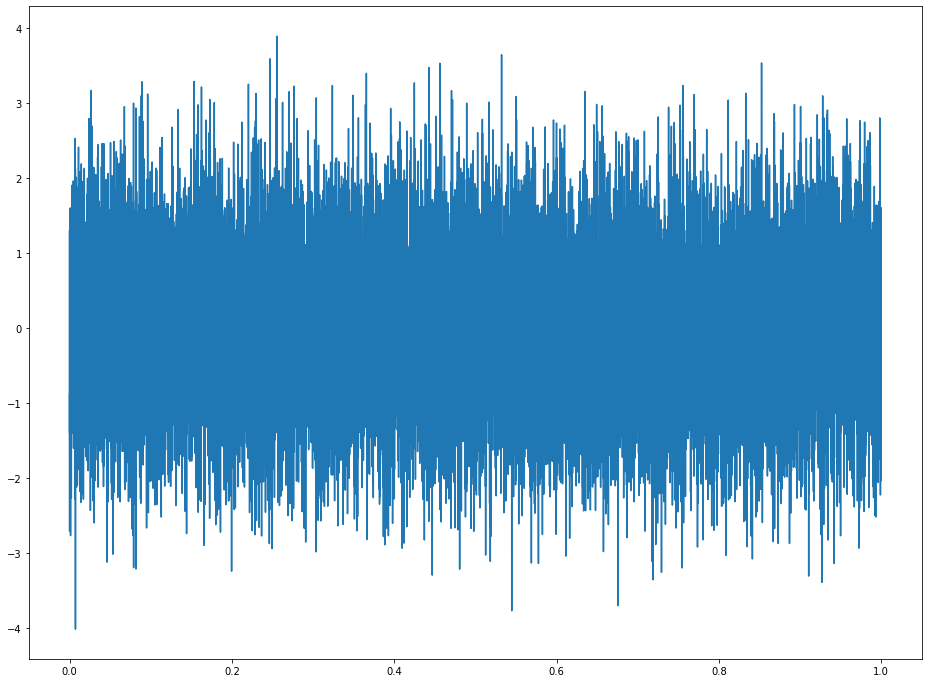

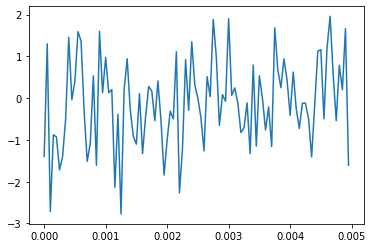

In [2]:
def generate_uniform_dist_waveform(n):
    return np.random.random(n)


def generate_phase_scrambled_waveform(n):
    cycle_len = 3000
    x = (np.arange(n) % cycle_len == cycle_len // 3).astype(np.int)
    
    x_fft = np.fft.rfft(x)
    pshift = np.arange(len(x_fft))**1.5
    x_pshift = np.fft.irfft(x_fft * (np.cos(pshift) + 1j*np.sin(pshift)))
    
    return 10*x_pshift


def generate_binary_waveform(n):
    return (np.random.random(n) > 0.5).astype(np.float)


def normal_distr_waveform(n):
    return np.random.normal(size=n)
    
    
x = pd.Series(normal_distr_waveform(20000))
x.index = x.index / len(x)


print('no. of samples:', len(x))
print(x.head())

plt.figure(figsize=(16, 12))
plt.plot(x)
plt.show()

plt.plot(x.iloc[:100])
plt.show()

In [3]:
display(x.to_numpy())

array([-1.39770805,  1.2981882 , -2.71228987, ...,  0.07466734,
        1.42906199, -0.17422489])

## Calculating pusle-width sums

In [4]:
def pulse_mean_distr(series, max_samples=None):
    array = series.to_numpy()
    
    t_diffs = np.diff(series.index)
    delta_t = np.mean(t_diffs)
    np.testing.assert_allclose(t_diffs, delta_t)
    
    if max_samples is None:
        max_samples = len(series)

    result = np.empty(max_samples, dtype=np.object)
    result[0] = series
    for i in range(1, max_samples):
        result[i] = result[i-1].iloc[:-1] + array[i:]
    
    # test assertions
    np.testing.assert_allclose(result[0], array)
    np.testing.assert_allclose(result[1], array[:-1] + array[1:])
    np.testing.assert_allclose(result[2], array[:-2] + array[1:-1] + array[2:])
    
    result = pd.Series(
        result,
        index=delta_t*np.arange(1, max_samples+1)
    )
    return result / result.index

pwd = pulse_mean_distr(x)

### Checking results

In [5]:
for i in range(0, 25, 5):
    display(pwd.iloc[i])
    print(len(pwd.iloc[i]))

0.00000   -27954.160982
0.00005    25963.764077
0.00010   -54245.797459
0.00015   -17562.647449
0.00020   -18607.517232
               ...     
0.99975     1000.373950
0.99980    32048.006358
0.99985     1493.346759
0.99990    28581.239892
0.99995    -3484.497702
Length: 20000, dtype: float64

20000


0.00000   -21128.296539
0.00005   -21108.015578
0.00010   -27046.687382
0.00015   -13163.578434
0.00020   -10364.909808
               ...     
0.99950   -12952.306399
0.99955    -4888.300629
0.99960    -4889.992098
0.99965     4085.982612
0.99970     3143.137809
Length: 19995, dtype: float64

19995


0.00000   -11622.431313
0.00005    -6191.462940
0.00010    -6066.153015
0.00015    -1728.744791
0.00020    -2882.352731
               ...     
0.99925    -5957.392547
0.99930     -952.826099
0.99935    -1808.470786
0.99940    -1379.445670
0.99945     -478.978784
Length: 19990, dtype: float64

19990


0.00000   -7948.875015
0.00005   -5535.485881
0.00010   -9167.876386
0.00015   -3778.758254
0.00020   -2520.673201
              ...     
0.99900   -8605.721329
0.99905   -6914.174085
0.99910   -4034.654510
0.99915    -312.212462
0.99920   -1923.481726
Length: 19985, dtype: float64

19985


0.00000   -4509.120013
0.00005   -3056.957981
0.00010   -4099.127795
0.00015   -3550.474269
0.00020   -3084.536680
              ...     
0.99875   -6373.784426
0.99880   -4986.008625
0.99885   -5736.511218
0.99890   -4917.339381
0.99895   -3922.267720
Length: 19980, dtype: float64

19980


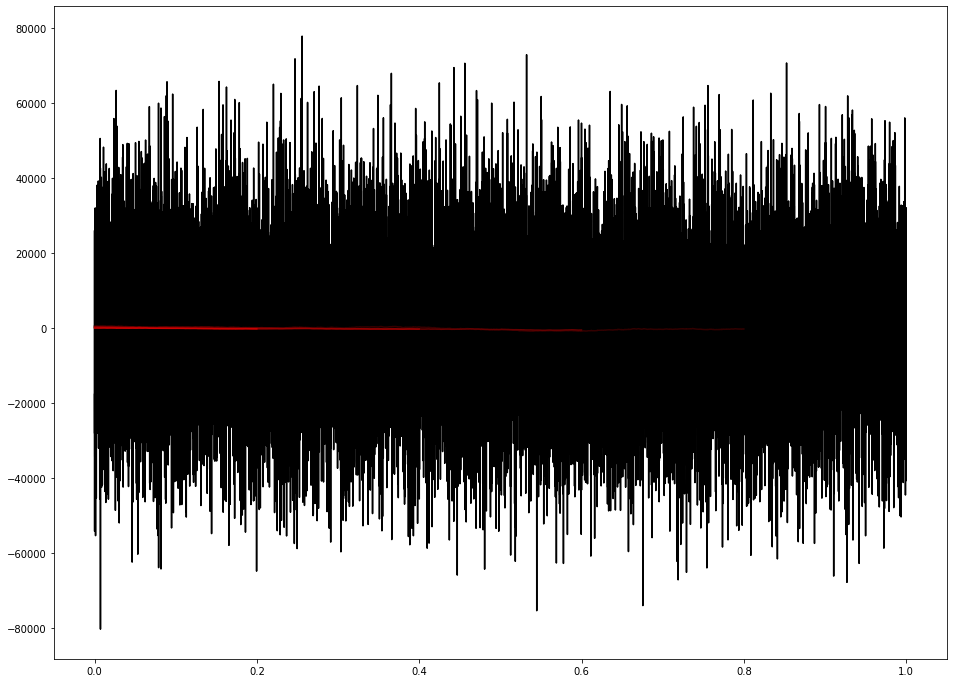

In [6]:
plt.figure(figsize=(16, 12))

for i, a in enumerate(pwd.iloc[:-1:4000]):
    plt.plot(a, color=((4000*i)/len(pwd), 0, 0))
    #plt.yscale('log')

plt.show()

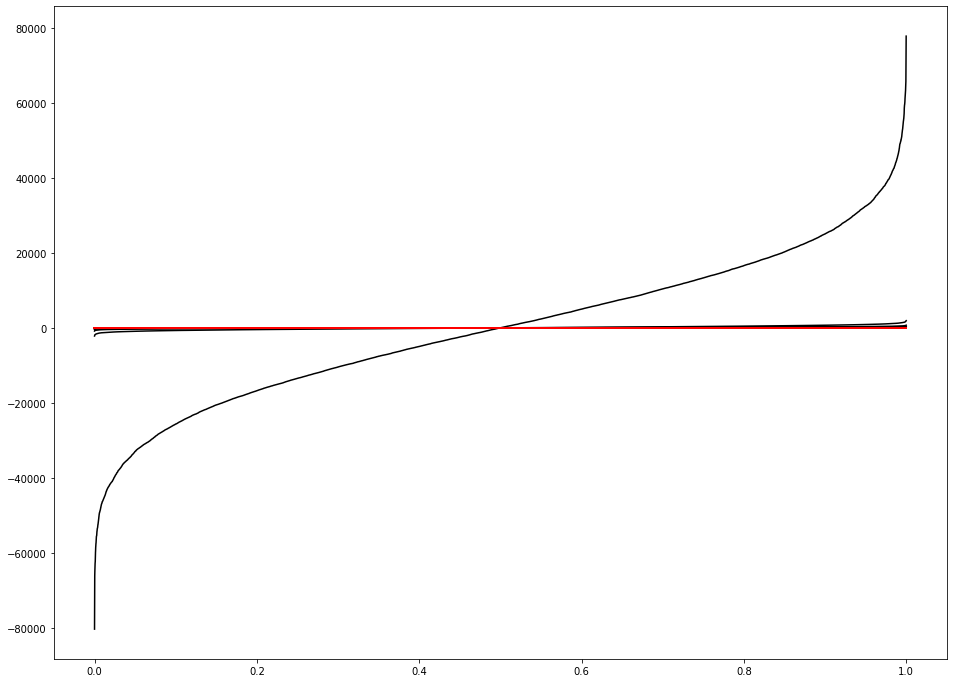

In [7]:
plt.figure(figsize=(16, 12))

for i, (a, idx) in enumerate(zip(pwd.iloc[::10], pwd.index[::10])):
    plt.plot(
        np.linspace(0, 1, len(a), endpoint=True),
        np.sort(a) / (i*10+1),
        color=(i*10/len(pwd), 0, 0),
    )
    #plt.yscale('log')

plt.show()

## Distribution plotting

### Helper Functions

In [8]:
import sys; sys.path.append('./..')
from distr_plot_helper import resize2D_to_rectangular, make_stack_plot_array

def widths_sequence(series, max_samples=None, max_quantiles=np.inf):
    pwd = pulse_mean_distr(series, max_samples)
    pwd_rect = resize2D_to_rectangular(pwd).T
    distr_array = make_stack_plot_array(pwd_rect, max_quantiles=max_quantiles)
    
    return distr_array, pwd.index

In [9]:
def make_colors(splits):
    splits = splits-2
    return [(0, 0, 0, 0)] + [
        3*(0.75*np.abs(i/(splits/2) - 1),) + (1,)
        for i in range(splits)
    ] + [(0, 0, 0, 0)]


### Plots

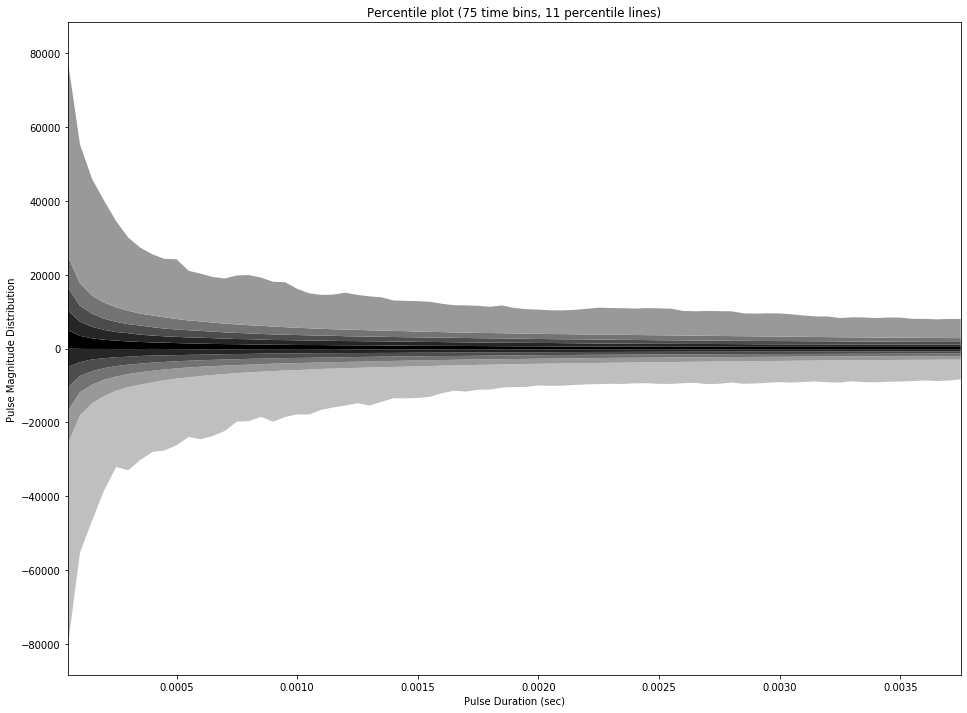

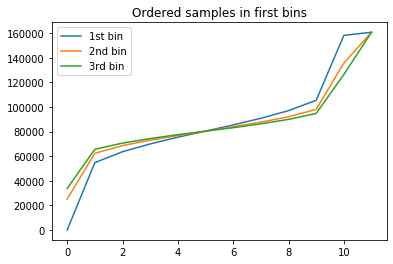

In [10]:
Y, X = widths_sequence(x, 75, 11)
#Y = Y[::10]
#X, Y = X[::100], Y[:, ::100]

plt.figure(figsize=(16, 12))
plt.stackplot(X, Y, colors=make_colors(Y.shape[0]), baseline='sym')
plt.title("Quantile plot ({1} time bins, {0} quantile lines)".format(Y.shape[0]-1, Y.shape[1]))
plt.xlim((X.min(), X.max()))
#plt.ylim((Y[:, 1:2].min(), Y[:, 1:2].max()))
plt.xlabel("Pulse Duration (sec)")
plt.ylabel("Pulse Magnitude Distribution")
plt.show()

plt.plot(np.cumsum(Y[:, 0]), label='1st bin')
plt.plot(np.cumsum(Y[:, 1]), label='2nd bin')
plt.plot(np.cumsum(Y[:, 2]), label='3rd bin')
plt.title("Ordered samples in first bins")
plt.legend()
plt.show()

# Aggregation Method: RMS

For [**RMS aggregation**](https://en.wikipedia.org/wiki/Root_mean_square#Definition), we plot the values

$G(t, T) = \sqrt{\frac{1}{T}\int_t^{t+T} {\left|f(\tau)\right|}^2 d\tau}$

## Calculating pusle-width RMS's

In [11]:
def pulse_rms_distr(series, max_samples=None):
    array = series.to_numpy() ** 2
    
    t_diffs = np.diff(series.index)
    delta_t = np.mean(t_diffs)
    np.testing.assert_allclose(t_diffs, delta_t)
    
    if max_samples is None:
        max_samples = len(series)

    result = np.empty(max_samples, dtype=np.object)
    result[0] = np.abs(series)
    for i in range(1, max_samples):
        result[i] = np.sqrt(result[i-1].iloc[:-1]**2 + array[i:])
    
    # test assertions
    np.testing.assert_allclose(result[0], np.sqrt(array))
    np.testing.assert_allclose(result[1], np.sqrt(array[:-1] + array[1:]))
    np.testing.assert_allclose(result[2], np.sqrt(array[:-2] + array[1:-1] + array[2:]))
    
    result = pd.Series(
        result,
        index=delta_t*np.arange(1, max_samples+1)
    )
    return result / result.index

pwd = pulse_rms_distr(x)

## Plotting

### Helper Functions

In [12]:
from distr_plot_helper import resize2D_to_rectangular, make_stack_plot_array

def widths_sequence(series, max_samples=None, max_quantiles=np.inf):
    pwd = pulse_rms_distr(series, max_samples)
    pwd_rect = resize2D_to_rectangular(pwd).T
    distr_array = make_stack_plot_array(pwd_rect, max_quantiles=max_quantiles)
    
    return distr_array, pwd.index

### Plots

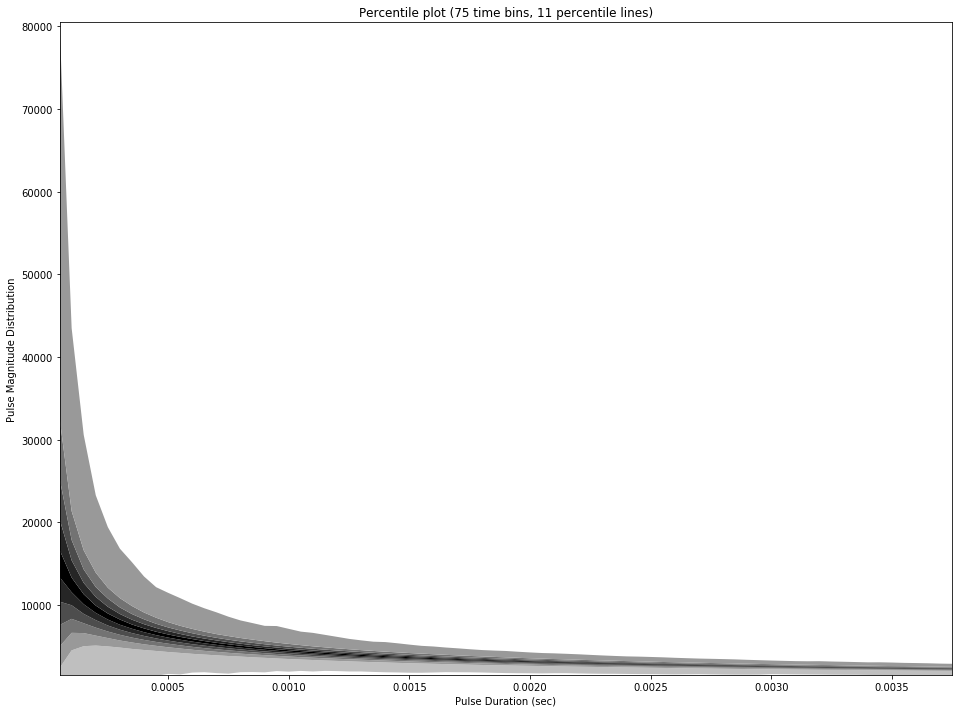

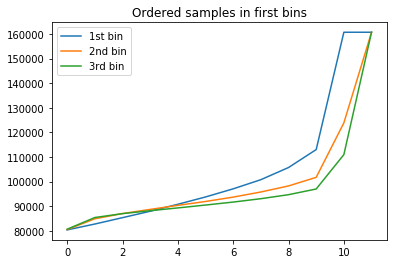

In [13]:
Y, X = widths_sequence(x, 75, 11)
#Y = Y[::10]
#X, Y = X[::100], Y[:, ::100]

plt.figure(figsize=(16, 12))
plt.stackplot(X, Y, colors=make_colors(Y.shape[0]), baseline='sym')
plt.title("Quantile plot ({1} time bins, {0} quantile lines)".format(Y.shape[0]-1, Y.shape[1]))
plt.xlim((X.min(), X.max()))
plt.ylim((Y[:, 1:2].min(), Y[:, 1:2].max()))
plt.xlabel("Pulse Duration (sec)")
plt.ylabel("Pulse Magnitude Distribution")
plt.show()

plt.plot(np.cumsum(Y[:, 0]), label='1st bin')
plt.plot(np.cumsum(Y[:, 1]), label='2nd bin')
plt.plot(np.cumsum(Y[:, 2]), label='3rd bin')
plt.title("Ordered samples in first bins")
plt.legend()
plt.show()

# (TODO) Aggregation Method: Frequency-Band RMS

For **frequency-banded RMS aggregation**, we make use of [Parseval's Theorem](https://en.wikipedia.org/wiki/Parseval%27s_identity) to calculate the RMS of each pulse over specific frequencies. This is described as

$H_{\omega_1, \omega_2}(t, T)
    = \sqrt{\frac{1}{T} \int_{\omega_1}^{\omega_2}
    {\left| \int_t^{t+T} f(\tau)\cdot \exp(-j\omega\tau) d\tau \right|}^2
    d\omega}$

where $\left[\int_t^{t+T} f(\tau)\cdot \exp(-j\omega\tau) d\tau\right]$ is the Fourier Series of $f$ computed over the reduced timespan $[t, t+T]$

- to ensure that each frequency has at least a full period of samples, $T$ should be restricted s.t. $T \geq \frac{2\pi}{\omega_1} \left(> \frac{2\pi}{\omega_2}\right)$

## Calculating pusle-width FRMS's

In [14]:
def pulse_fft_distr(series, rel_period, max_samples=None):
    assert rel_period in range(1, len(series)+1)
    series = series * np.exp(1j * (2*np.pi/rel_period) * np.arange(len(series)))
    array = series.to_numpy()
    
    t_diffs = np.diff(series.index)
    delta_t = np.mean(t_diffs)
    np.testing.assert_allclose(t_diffs, delta_t)

    if max_samples is None:
        max_samples = len(series)
    else:
        max_samples = max_samples + rel_period
        
    result = np.empty(max_samples, dtype=np.object)
    result[0] = series
    for i in range(1, max_samples):
        result[i] = result[i-1].iloc[:-1] + array[i:]
    
    # test assertions
    np.testing.assert_allclose(result[0], array)
    np.testing.assert_allclose(result[1], array[:-1] + array[1:])
    np.testing.assert_allclose(result[2], array[:-2] + array[1:-1] + array[2:])
    
    result = pd.Series(result, index=delta_t*np.arange(1, max_samples+1))
    return result[rel_period-1:]


def pulse_frms_distr(series, freq_lbound=None, freq_ubound=None, max_samples=None):
    rel_period_range = range(
        1 if freq_ubound is None else 1+np.searchsorted(series.index, 1/freq_ubound),
        len(series) if freq_lbound is None else np.searchsorted(series.index, 1/freq_lbound, side='right'),
    )
    assert rel_period_range
    
    result = np.abs(pulse_fft_distr(series, rel_period_range[0], max_samples)) ** 2
    for i, rel_period in enumerate(rel_period_range[1:], 1):
        print(i)
        result[i:] += np.abs(pulse_fft_distr(series, rel_period, max_samples and max_samples-i)) ** 2
    
    return np.sqrt(result / result.index)

pfd = pulse_frms_distr(x, 500, 600)

1
2
3
4
5


In [15]:
import itertools

def pulse_fft_distr(series, rel_period_range, max_samples=None):
    assert rel_period_range[0] in range(1, len(series)+1)
    assert rel_period_range[1] in range(2, len(series)+2)
    
    array = series.to_numpy()
    times = series.index
    t_diffs = np.diff(times)
    delta_t = np.mean(t_diffs)
    np.testing.assert_allclose(t_diffs, delta_t)

    freq_coeffs = (array * np.exp(
        1j * (2*np.pi/np.arange(*rel_period_range)[..., np.newaxis]) * np.arange(len(series))
    )).T

    def gen_freq_pulse_widths(array):
        agg_array = array

        for rel_T in range(1, len(array)+1):
            yield rel_T, agg_array
            agg_array = agg_array[:-1] + array[rel_T:]
    
    def gen_pulse_widths(iterable):
        return (
            (
                rel_T,
                pd.Series(
                    np.sqrt(np.sum(np.abs(agg_freqs)**2, axis=-1) / (rel_T*delta_t)),
                    index=times[:len(times)-rel_T+1]
                ),
            )
            for (rel_T, agg_freqs) in iterable
        )

    rel_periods, pulse_widths = zip(
        *itertools.islice(
            gen_pulse_widths(gen_freq_pulse_widths(freq_coeffs)),
            rel_period_range[0],
            max_samples and rel_period_range[0]+max_samples,
        )
    )
    
    return pd.Series(pulse_widths, index=delta_t*np.array(rel_periods))


def pulse_frms_distr(series, freq_lbound=None, freq_ubound=None, max_samples=None):
    rel_period_range = (
        1 if freq_ubound is None else 1+np.searchsorted(series.index, 1/freq_ubound),
        len(series) if freq_lbound is None else 1+np.searchsorted(series.index, 1/freq_lbound, side='right'),
    )
    assert range(*rel_period_range)
    
    return pulse_fft_distr(series, rel_period_range, max_samples)

#pfd = pulse_frms_distr(x, 500, 600)

## Plotting

### Helper Functions

In [16]:
from distr_plot_helper import resize2D_to_rectangular, make_stack_plot_array

def widths_sequence(series, freq_lbound=None, freq_ubound=None, max_samples=None, max_quantiles=np.inf):
    pwd = pulse_frms_distr(series, freq_lbound, freq_ubound, max_samples)
    pwd_rect = resize2D_to_rectangular(pwd).T
    distr_array = make_stack_plot_array(pwd_rect, max_quantiles=max_quantiles)
    
    return distr_array, pwd.index

### Plots

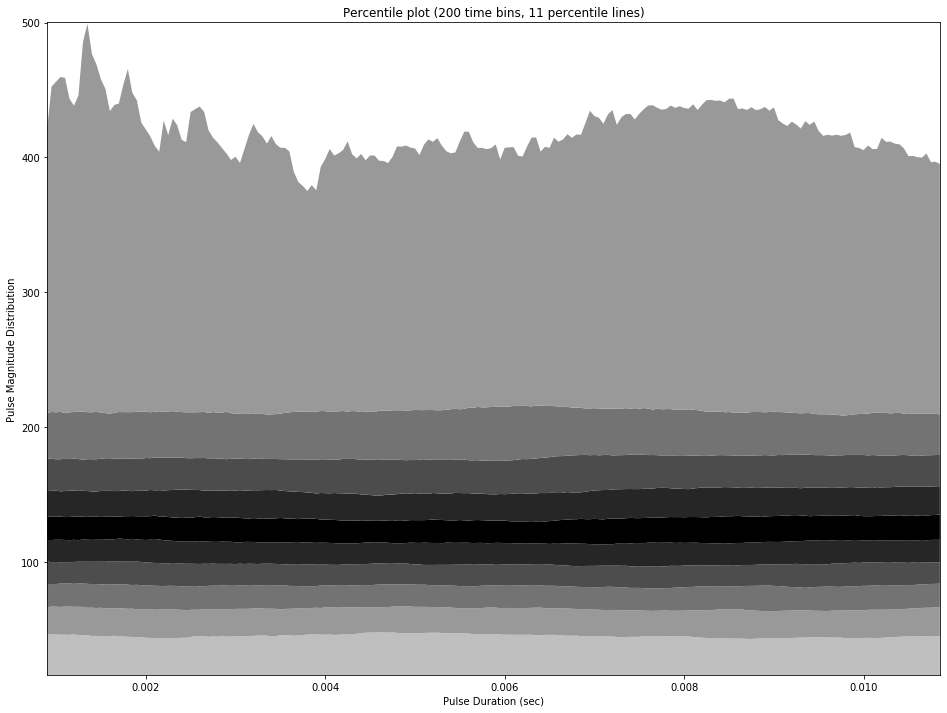

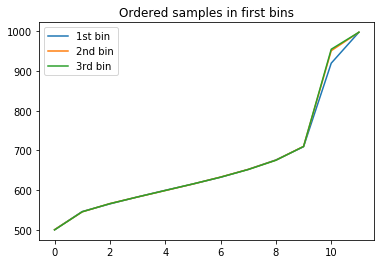

In [17]:
Y, X = widths_sequence(x, 1200, 1300, max_samples=200, max_quantiles=11)
#Y = Y[::10]
#X, Y = X[::100], Y[:, ::100]

plt.figure(figsize=(16, 12))
plt.stackplot(X, Y, colors=make_colors(Y.shape[0]), baseline='sym')
plt.title("Quantile plot ({1} time bins, {0} quantile lines)".format(Y.shape[0]-1, Y.shape[1]))
plt.xlim((X.min(), X.max()))
plt.ylim((Y[:, 1:2].min(), Y[:, 1:2].max()))
plt.xlabel("Pulse Duration (sec)")
plt.ylabel("Pulse Magnitude Distribution")
plt.show()

plt.plot(np.cumsum(Y[:, 0]), label='1st bin')
plt.plot(np.cumsum(Y[:, 1]), label='2nd bin')
plt.plot(np.cumsum(Y[:, 2]), label='3rd bin')
plt.title("Ordered samples in first bins")
plt.legend()
plt.show()